In [25]:
# HVAC Energy Prediction Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

**This implements a machine - learning - based HVAC energy prediction pipeline. It conducts 
feature engineering to create relevant features, trains baseline models like linear 
regression, random forest, and XGBoost. Results include model performance metrics and feature 
importance. Visualizations such as model error bar plots and SHAP value bar plots are 
generated to illustrate findings.**

In [26]:
# 1. Feature Engineering
def prepare_features(df, target_col='WH_RTU_Total'):
    """
    Create optimized feature matrix with domain-specific features

    Args:
        df: Raw DataFrame with timestamp index
        target_col: Name of target energy column

    Returns:
        X: Feature matrix
        y: Target vector
        feature_names: List of feature names
    """
    features = df.copy()

    # ================== time-specificity ==================
    features['hour'] = features.index.hour
    features['day_of_week'] = features.index.dayofweek
    features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)
    features['is_business_hours'] = ((features['hour'] >= 8) & (features['hour'] <= 18)).astype(int)

    # ================== weather characteristics ==================
    # Temperature related
    features['temp_diff_out_ret'] = features['T_out'] - features['T_Ret_RTU']
    features['temp_diff_out_sup'] = features['T_out'] - features['T_Sup_RTU']

    # Heat load estimation
    features['cooling_load_estimate'] = features['AF_RTU'] * (features['T_Ret_RTU'] - features['T_Sup_RTU'])

    # solarization
    features['solar_impact'] = features['Glo_Solar'] * (features['hour'].apply(
        lambda x: max(0, (12 - abs(x - 12)) / 12)))

    # ================== System Operational Characteristics ==================
    # Compressor operating status
    features['compressor_running'] = ((features['WH_RTU_Comp1'] > 0) |
                                      (features['WH_RTU_Comp2'] > 0)).astype(int)
    features['both_compressors'] = ((features['WH_RTU_Comp1'] > 0) &
                                    (features['WH_RTU_Comp2'] > 0)).astype(int)

    # System efficiency indicators
    features['cop_instant'] = features['cooling_load_estimate'] / (features['WH_RTU_Total'] + 1e-6)

    # Statistical Characterization of End Units (Example of Selected VAVs)
    vav_list = ['102', '103', '104', '105', '106', '202', '203', '204', '205', '206']
    valid_vav_flow_cols = [f'AF_VAV_{v}' for v in vav_list if f'AF_VAV_{v}' in features.columns]
    valid_room_temp_cols = [f'T_Room_{v}' for v in vav_list if f'T_Room_{v}' in features.columns]
    valid_vav_temp_cols = [f'T_VAV_{v}' for v in vav_list if f'T_VAV_{v}' in features.columns]

    features['avg_vav_flow'] = np.mean(features[valid_vav_flow_cols], axis=1) if valid_vav_flow_cols else np.nan
    temp_diffs = [features[room_col] - features[vav_col] for room_col, vav_col in zip(valid_room_temp_cols, valid_vav_temp_cols)]
    features['max_room_temp_diff'] = np.max(temp_diffs, axis=0) if temp_diffs else np.nan

    # ================== Hysteresis and rolling characteristics ==================
    # 24-hour lag characteristic
    lag_cols = ['WH_RTU_Total', 'T_out', 'RH_out', 'AF_RTU']
    for col in lag_cols:
        features[f'{col}_lag24h'] = features[col].shift(24)

    # Rolling window feature (24 hours)
    rolling_cols = ['T_out', 'WH_RTU_Total', 'AF_RTU']
    for col in rolling_cols:
        features[f'{col}_rolling_mean_24h'] = features[col].rolling(24).mean()
        features[f'{col}_rolling_std_24h'] = features[col].rolling(24).std()

    # ================== Anomaly Detection Characteristics==================
    # Simultaneous heating and cooling detection (if relevant fields exist)
    if 'ClgPct' in features and 'HtgPct' in features:
        features['simultaneous_hc'] = ((features['ClgPct'] > 10) & (features['HtgPct'] > 10)).astype(int)

    # Air volume imbalance detection
    features['airflow_imbalance'] = features['AF_RTU'] - features[valid_vav_flow_cols].sum(axis=1)

    # ================== Final Feature Selection==================
    selected_features = [
        # Weather-related
        'T_out', 'RH_out', 'Glo_Solar', 'WS',
        'temp_diff_out_ret', 'temp_diff_out_sup',
        'solar_impact',

        # system operation
        'AF_RTU', 'T_Ret_RTU', 'T_Sup_RTU',
        'WH_RTU_Comp1', 'WH_RTU_Comp2',
        'compressor_running', 'both_compressors',
        'cop_instant',

        # end unit
        'avg_vav_flow', 'max_room_temp_diff',

        # time-specificity
        'hour', 'is_weekend', 'is_business_hours',

        # hysteresis feature
        'WH_RTU_Total_lag24h', 'T_out_lag24h',
        'T_out_rolling_mean_24h', 'AF_RTU_rolling_mean_24h',

        # anomaly detection
        'airflow_imbalance'
    ]

    # Remove rows containing NA
    features = features.dropna(subset=selected_features + [target_col])

    return features[selected_features], features[target_col], selected_features

In [27]:
# 2. Baseline Modeling
def train_baseline_models(X, y):
    """
    Train and evaluate baseline models
    
    Returns:
        Dictionary of model performance metrics
    """
    # Train-test split with temporal ordering
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    }
    
    # Train and evaluate
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': model.score(X_test_scaled, y_test)
        }
    
        
    
    return pd.DataFrame(results).T

In [28]:

# 3. Feature Importance Analysis
def analyze_feature_importance(X, y, feature_names):
    """
    Perform feature importance analysis using multiple methods
    
    Returns:
        Dictionary of importance dataframes
    """
    # Train XGBoost model
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    xgb.fit(X, y)
    
    # SHAP analysis
    explainer = shap.Explainer(xgb)
    shap_values = explainer(X)
    
    # Get importance scores
    importance_data = {
        'XGBoost Gain': xgb.get_booster().get_score(importance_type='gain'),
        'SHAP Values': pd.Series(np.abs(shap_values.values).mean(axis=0), index=feature_names)
    }
    
    return importance_data

In [29]:
# 4. Visualization
def plot_results(metrics_df, importance_data):
    """Visualize model performance and feature importance"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Model performance
    metrics_df[['MAE', 'RMSE']].plot(kind='bar', ax=ax1)
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylabel('Error (Wh)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Feature importance
    importance_data['SHAP Values'].sort_values().plot(kind='barh', ax=ax2)
    ax2.set_title('Feature Importance (SHAP Values)')
    ax2.set_xlabel('Mean Absolute SHAP Value')
    
    plt.tight_layout()
    plt.show()

Created 25 features

Model Performance:


,MAE,RMSE,R2
Linear Regression,177.417540,226.703837,0.988184
Random Forest,66.254594,177.154445,0.992785
XGBoost,55.250346,96.147811,0.997875


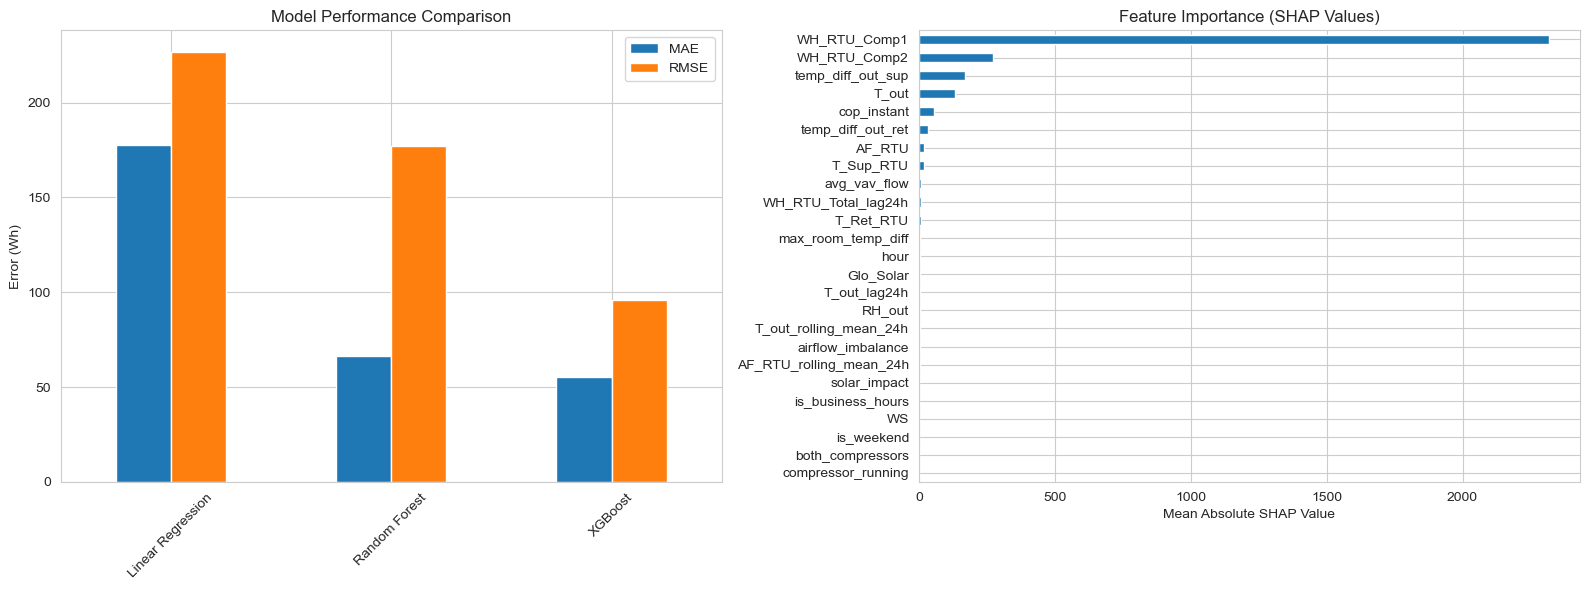

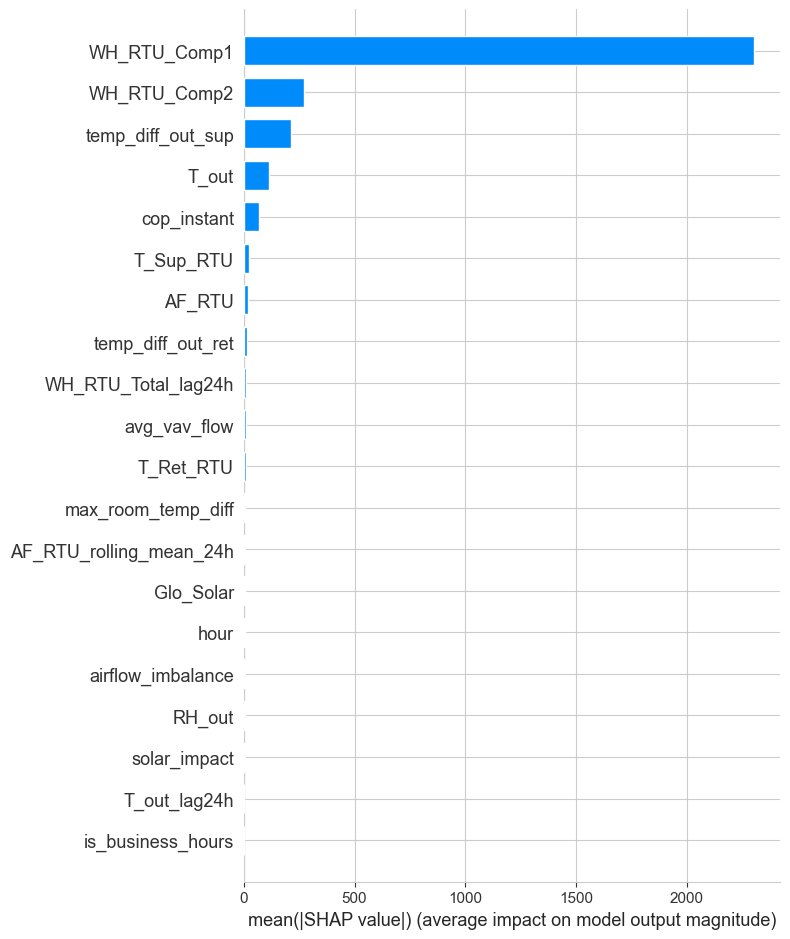

In [30]:
# Load and preprocess data (replace with your data loading)
df = pd.read_csv('../../outputs/HVAC_cleaned_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
    
# 1. Feature Engineering
X, y, feature_names = prepare_features(df)
print(f"Created {len(feature_names)} features")
    
# 2. Baseline Models
metrics_df = train_baseline_models(X, y)
print("\nModel Performance:")
display(metrics_df)
    
# 3. Feature Importance
importance_data = analyze_feature_importance(X, y, feature_names)
    
# 4. Visualization
plot_results(metrics_df, importance_data)
    
# Optional: SHAP summary plot
explainer = shap.Explainer(XGBRegressor().fit(X, y))
shap_values = explainer(X)
shap.summary_plot(shap_values, X, plot_type='bar')
